In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!unzip "/content/drive/MyDrive/yolov8_gtsdb_backup/runs_backup.zip" -d "/content/runs_backup"

Archive:  /content/drive/MyDrive/yolov8_gtsdb_backup/runs_backup.zip
   creating: /content/runs_backup/detect/
   creating: /content/runs_backup/detect/train/
   creating: /content/runs_backup/detect/train/weights/
  inflating: /content/runs_backup/detect/train/labels_correlogram.jpg  
  inflating: /content/runs_backup/detect/train/labels.jpg  
  inflating: /content/runs_backup/detect/train/train_batch2.jpg  
  inflating: /content/runs_backup/detect/train/train_batch0.jpg  
  inflating: /content/runs_backup/detect/train/train_batch1.jpg  
  inflating: /content/runs_backup/detect/train/args.yaml  
  inflating: /content/runs_backup/detect/train/results.csv  
  inflating: /content/runs_backup/detect/train/weights/last.pt  
  inflating: /content/runs_backup/detect/train/weights/best.pt  


In [7]:
!pip install ultralytics opencv-python matplotlib tensorflow numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling n

In [8]:
import os
from PIL import Image

def convert_ppm_to_jpg(folder_path):
    for filename in os.listdir(folder_path):
        if filename.lower().endswith('.ppm'):
            ppm_path = os.path.join(folder_path, filename)
            jpg_path = os.path.join(folder_path, filename.replace('.ppm', '.jpg'))
            with Image.open(ppm_path) as img:
                img.convert("RGB").save(jpg_path, "JPEG")

convert_ppm_to_jpg("/content/drive/MyDrive/Traffic_Sign_Recognition/ML_Dataset/gtsdb/TestIJCNN2013/TestIJCNN2013Download")

In [9]:
from ultralytics import YOLO
import torch
import pandas as pd
import tensorflow as tf
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.initializers import HeNormal


yolo_model = YOLO("/content/runs_backup/detect/train/weights/best.pt")

def create_cnn(num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', kernel_initializer=HeNormal(), input_shape=(32, 32, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal()),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', kernel_initializer=HeNormal()),
        BatchNormalization(),

        Flatten(),
        Dense(256, activation='relu', kernel_initializer=HeNormal()),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

cnn_model = create_cnn(43)
cnn_model.load_weights("/content/drive/MyDrive/traffic_sign_model.h5")

def predict_traffic_sign(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("⚠️ Failed to read image.")
        return

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = yolo_model(image)

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cropped = image[y1:y2, x1:x2]

            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)

            label = f"{yolo_model.names[int(box.cls)]} {box.conf.item():.2f}"


            (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
            cv2.rectangle(image_rgb, (x1, y1 - 20), (x1 + w, y1), (0, 255, 0), -1)

            cv2.putText(image_rgb, label, (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)

            cropped = cv2.resize(cropped, (32, 32))
            cropped = cropped / 255.0
            cropped = cropped.reshape(1, 32, 32, 3)

            pred = cnn_model.predict(cropped, verbose=0)
            class_id = np.argmax(pred)
            print(f"✅ Detected Traffic Sign Class (CNN): {class_id}")


    plt.imshow(image_rgb)
    plt.title("Detected Signs")
    plt.axis("off")
    plt.show()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



0: 384x640 1 Speed limit (30km/h), 1067.6ms
Speed: 11.8ms preprocess, 1067.6ms inference, 30.8ms postprocess per image at shape (1, 3, 384, 640)
✅ Detected Traffic Sign Class (CNN): 1


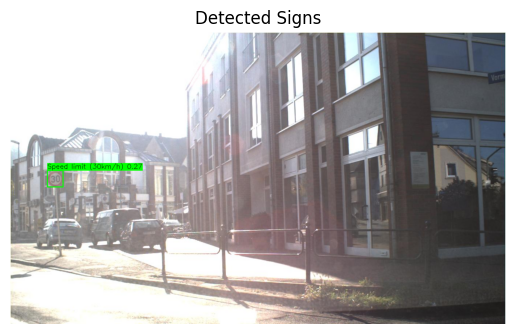

In [10]:
img_path="/content/drive/MyDrive/Traffic_Sign_Recognition/ML_Dataset/gtsdb/TestIJCNN2013/TestIJCNN2013Download/00032.jpg"
predict_traffic_sign(img_path)


In [15]:
img_path="/content/drive/MyDrive/Traffic_Sign_Recognition/ML_Dataset/gtsdb/train/images/00096.jpg"
predict_traffic_sign(img_path)

⚠️ Failed to read image.



0: 384x640 (no detections), 893.3ms
Speed: 5.4ms preprocess, 893.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


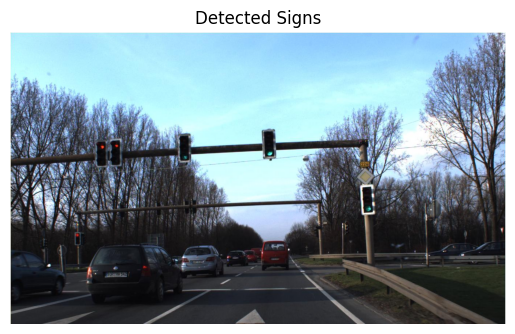

In [16]:
img_path="/content/drive/MyDrive/Traffic_Sign_Recognition/ML_Dataset/gtsdb/TestIJCNN2013/TestIJCNN2013Download/00008.jpg"
predict_traffic_sign(img_path)
